In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'logit'

In [4]:
# Parameters
model_size = "7b"
target_lang = "fr"
input_lang = "ru"
type = "tuned"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
    
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

params.pt AlignmentResearch/tuned-lens space main lens/meta-llama/Llama-2-7b-hf None


params.pt:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

(…)ens/meta-llama/Llama-2-7b-hf/config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [7]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation': target_lang if target_lang != 'en' else 'en_tgt'}, 
                                inplace=True)
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation_{target_lang}': target_lang if target_lang != 'en' else 'en_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != 'en' else 'en_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != 'en':
    for i, row in df_en_target_input.iterrows():
        if row['en'].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_en_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for fr 68 of 118 are single tokens
final length of df_en_fr_ru: 88


In [8]:
df_en_target_input

,lang_fr,en,fr,blank_prompt_original_fr,blank_prompt_translation_fr,blank_prompt_translation_masked_fr,error_fr,lang_ru,ru,blank_prompt_original_ru,blank_prompt_translation_ru,blank_prompt_translation_masked_ru,error_ru
0,fr,cloud,nuage,"A ""cloud"" is a visible mass of condensed water...","Un ""nuage"" est une masse visible de vapeur d'e...","Un ""___"" est une masse visible de vapeur d'eau...",no error,ru,облако,"A ""cloud"" is a visible mass of condensed water...",Облако - это видимая масса конденсированного в...,"""___"" - это видимая масса конденсированного во...",no error
1,fr,bag,sac,"A ""bag"" is used to carry items. Answer: ""bag"".","Un ""sac"" est utilisé pour transporter des obje...","Un ""___"" est utilisé pour transporter des obje...",no error,ru,сумка,"A ""bag"" is used to carry items. Answer: ""bag"".",Сумка используется для переноски предметов. От...,"""___"" используется для переноски предметов. От...",no error
2,fr,mouth,bouche,"A ""mouth"" is used to eat food and speak. Answe...","La ""bouche"" sert à manger et à parler. Réponse...","La ""___"" sert à manger et à parler. Réponse : ...",no error,ru,рот,"A ""mouth"" is used to eat food and speak. Answe...",Рот используется для приема пищи и речи. Ответ...,"""___"" используется для приема пищи и речи. Отв...",no error
3,fr,soil,sol,"""A ""soil"" is used for planting trees and crops...","""Un ""sol"" est utilisé pour planter des arbres ...","""Un ""___"" est utilisé pour planter des arbres ...",no error,ru,почва,"""A ""soil"" is used for planting trees and crops...","""Почва"" используется для посадки деревьев и вы...","""___"" используется для посадки деревьев и выра...",no error
4,fr,mountain,montagne,"A ""mountain"" is a large natural elevation of t...","Une ""montagne"" est une grande élévation nature...","Une ""___"" est une grande élévation naturelle d...",no error,ru,гора,"A ""mountain"" is a large natural elevation of t...",Гора - это крупное естественное возвышение зем...,"""___"" - это крупное естественное возвышение зе...",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,fr,tower,tour,"A ""tower"" is a tall structure that can be used...","Une ""tour"" est une structure haute qui peut êt...","Une ""___"" est une structure haute qui peut êtr...",no error,ru,башня,"A ""tower"" is a tall structure that can be used...","Башня - это высокое сооружение, которое может ...","""___"" - это высокое сооружение, которое может ...",no error
100,fr,office,bureau,"An ""office"" is a place where people usually do...","Un ""bureau"" est un endroit où les gens font ha...","Un ""___"" est un endroit où les gens font habit...",no error,ru,офис,"An ""office"" is a place where people usually do...","Офис - это место, где люди обычно выполняют св...","""___"" - это место, где люди обычно выполняют с...",no error
101,fr,sound,son,"A ""sound"" is something we hear. Answer: ""sound"".","Un ""son"" est quelque chose que l'on entend. Ré...","Un ""___"" est quelque chose que l'on entend. Ré...",no error,ru,звук,"A ""sound"" is something we hear. Answer: ""sound"".","Звук - это то, что мы слышим. Ответ: ""звук"".","""___"" - это то, что мы слышим. Ответ: ""звук"".",no error
102,fr,power,pouvoir,"""A ""power"" is used to control or influence peo...","""Un ""pouvoir"" est utilisé pour contrôler ou in...","""Un ""___"" est utilisé pour contrôler ou influe...",no error,ru,власть,"""A ""power"" is used to control or influence peo...","""Власть"" используется для контроля или влияния...","""___"" используется для контроля или влияния на...",no error


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != 'en' and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                        | 0/88 [00:00<?, ?it/s]

  1%|██▎                                                                                                                                                                                                             | 1/88 [00:00<00:20,  4.34it/s]

  2%|████▋                                                                                                                                                                                                           | 2/88 [00:00<00:16,  5.32it/s]

  3%|███████                                                                                                                                                                                                         | 3/88 [00:00<00:17,  4.83it/s]

  5%|█████████▍                                                                                                                                                                                                      | 4/88 [00:00<00:16,  5.22it/s]

  6%|███████████▊                                                                                                                                                                                                    | 5/88 [00:01<00:19,  4.18it/s]

  7%|██████████████▏                                                                                                                                                                                                 | 6/88 [00:01<00:18,  4.55it/s]

  8%|████████████████▌                                                                                                                                                                                               | 7/88 [00:01<00:17,  4.58it/s]

  9%|██████████████████▉                                                                                                                                                                                             | 8/88 [00:01<00:17,  4.63it/s]

 10%|█████████████████████▎                                                                                                                                                                                          | 9/88 [00:02<00:18,  4.21it/s]

 11%|███████████████████████▌                                                                                                                                                                                       | 10/88 [00:02<00:16,  4.59it/s]

 12%|█████████████████████████▉                                                                                                                                                                                     | 11/88 [00:02<00:17,  4.39it/s]

 14%|████████████████████████████▏                                                                                                                                                                                  | 12/88 [00:02<00:16,  4.53it/s]

 15%|██████████████████████████████▌                                                                                                                                                                                | 13/88 [00:02<00:17,  4.34it/s]

 16%|████████████████████████████████▉                                                                                                                                                                              | 14/88 [00:03<00:16,  4.49it/s]

 17%|███████████████████████████████████▎                                                                                                                                                                           | 15/88 [00:03<00:15,  4.63it/s]

 18%|█████████████████████████████████████▋                                                                                                                                                                         | 16/88 [00:03<00:14,  5.08it/s]

 19%|███████████████████████████████████████▉                                                                                                                                                                       | 17/88 [00:03<00:14,  5.07it/s]

 20%|██████████████████████████████████████████▎                                                                                                                                                                    | 18/88 [00:03<00:13,  5.05it/s]

 22%|████████████████████████████████████████████▋                                                                                                                                                                  | 19/88 [00:04<00:14,  4.90it/s]

 23%|███████████████████████████████████████████████                                                                                                                                                                | 20/88 [00:04<00:12,  5.29it/s]

 24%|█████████████████████████████████████████████████▍                                                                                                                                                             | 21/88 [00:04<00:12,  5.37it/s]

 25%|███████████████████████████████████████████████████▊                                                                                                                                                           | 22/88 [00:04<00:12,  5.43it/s]

 26%|██████████████████████████████████████████████████████                                                                                                                                                         | 23/88 [00:04<00:11,  5.43it/s]

 27%|████████████████████████████████████████████████████████▍                                                                                                                                                      | 24/88 [00:04<00:12,  5.13it/s]

 28%|██████████████████████████████████████████████████████████▊                                                                                                                                                    | 25/88 [00:05<00:12,  5.10it/s]

 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                                 | 26/88 [00:05<00:12,  4.83it/s]

 31%|███████████████████████████████████████████████████████████████▌                                                                                                                                               | 27/88 [00:05<00:11,  5.30it/s]

 32%|█████████████████████████████████████████████████████████████████▊                                                                                                                                             | 28/88 [00:05<00:11,  5.16it/s]

 33%|████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 29/88 [00:05<00:10,  5.58it/s]

 34%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 30/88 [00:06<00:11,  5.18it/s]

 35%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 31/88 [00:06<00:10,  5.23it/s]

 36%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 32/88 [00:06<00:11,  4.75it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 33/88 [00:06<00:10,  5.07it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 34/88 [00:06<00:11,  4.86it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 35/88 [00:07<00:11,  4.76it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 36/88 [00:07<00:10,  4.87it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 37/88 [00:07<00:10,  4.92it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 38/88 [00:07<00:10,  4.96it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 39/88 [00:07<00:09,  5.12it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 40/88 [00:08<00:08,  5.47it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 41/88 [00:08<00:08,  5.62it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 42/88 [00:08<00:09,  4.98it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 43/88 [00:08<00:09,  4.86it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 44/88 [00:08<00:09,  4.68it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 45/88 [00:09<00:09,  4.61it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 46/88 [00:09<00:08,  4.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 47/88 [00:09<00:08,  4.85it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 48/88 [00:09<00:09,  4.32it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 49/88 [00:10<00:08,  4.43it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 50/88 [00:10<00:09,  4.17it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 51/88 [00:10<00:09,  4.09it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 52/88 [00:10<00:08,  4.02it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 53/88 [00:11<00:08,  4.18it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 54/88 [00:11<00:07,  4.40it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 55/88 [00:11<00:07,  4.42it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 56/88 [00:11<00:07,  4.56it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 57/88 [00:12<00:07,  4.19it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 58/88 [00:12<00:07,  4.26it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 59/88 [00:12<00:06,  4.24it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 60/88 [00:12<00:07,  3.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 61/88 [00:13<00:06,  3.98it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 62/88 [00:13<00:07,  3.48it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 63/88 [00:13<00:06,  3.62it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 64/88 [00:13<00:06,  3.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 65/88 [00:14<00:05,  3.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 66/88 [00:14<00:06,  3.58it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/88 [00:14<00:05,  3.65it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 68/88 [00:14<00:05,  3.79it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 69/88 [00:15<00:05,  3.42it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 70/88 [00:15<00:04,  3.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 71/88 [00:15<00:04,  3.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 72/88 [00:15<00:04,  3.97it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 73/88 [00:16<00:03,  4.09it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 74/88 [00:16<00:03,  4.09it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 75/88 [00:16<00:03,  4.27it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 76/88 [00:16<00:03,  3.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 77/88 [00:17<00:02,  3.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 78/88 [00:17<00:02,  4.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 79/88 [00:17<00:02,  4.33it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 80/88 [00:17<00:01,  4.69it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 81/88 [00:18<00:01,  4.43it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 82/88 [00:18<00:01,  4.12it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 83/88 [00:18<00:01,  4.14it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 84/88 [00:18<00:00,  4.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 85/88 [00:19<00:00,  4.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 86/88 [00:19<00:00,  4.50it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 87/88 [00:19<00:00,  4.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:19<00:00,  4.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:19<00:00,  4.47it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"Русский: ""хвост"" - Français: ""queue""\nРусский:...","[29876, 4948, 3433, 302]",nuage,"[17184, 9570, 695, 9274, 15126, 274, 23642, 10...",cloud,облако
1,"Русский: ""юг"" - Français: ""sud""\nРусский: ""вид...","[4977, 269, 872, 7067, 29879]",sac,"[29890, 23156, 2291, 19548, 289, 9922]",bag,сумка
2,"Русский: ""песок"" - Français: ""sable""\nРусский:...","[1045, 29890, 16380, 833, 289]",bouche,"[4346, 29885, 29442, 2730, 13394, 21026, 286]",mouth,рот
3,"Русский: ""сиденье"" - Français: ""siège""\nРусски...","[274, 29883]",cœur,"[540, 29882, 8293, 354, 298, 23057, 5192]",heart,сердце
4,"Русский: ""красный"" - Français: ""rouge""\nРусски...","[611, 5530, 24402, 29885, 1667, 3396, 655, 286]",main,"[2350, 447, 5905, 29882, 1361, 5403, 298, 3179]",hand,рука
5,"Русский: ""долина"" - Français: ""vallée""\nРусски...","[1893, 2852, 904, 29948]",étoile,"[303, 380, 8508, 269, 9523, 5173, 5810, 29879]",star,звезда
6,"Русский: ""улица"" - Français: ""rue""\nРусский: ""...","[29878, 364, 1253, 18475, 620, 276, 690, 337]",ressort,"[4278, 29879, 7689, 805, 15099, 1028, 6709, 269]",spring,пружина
7,"Русский: ""слово"" - Français: ""mot""\nРусский: ""...","[8092, 6092, 301, 29880, 25081]",lune,"[4346, 29885, 2730, 18786, 286]",moon,луна
8,"Русский: ""танец"" - Français: ""danse""\nРусский:...","[305, 5815, 25875, 274, 10329, 521, 5083, 29883]",chanson,"[4823, 578, 269, 21453, 1487, 1100, 577, 29879]",song,песня
9,"Русский: ""лес"" - Français: ""forêt""\nРусский: ""...","[1893, 28899, 2852, 904, 29948]",étang,"[1112, 772, 12509, 282, 29886, 2818, 1129]",pond,пруд


In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(32):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.17it/s]

2it [00:01,  2.19it/s]

3it [00:01,  3.07it/s]

4it [00:01,  3.64it/s]

5it [00:01,  4.30it/s]

6it [00:01,  4.71it/s]

7it [00:01,  5.01it/s]

8it [00:02,  5.51it/s]

9it [00:02,  5.53it/s]

10it [00:02,  5.56it/s]

11it [00:02,  5.76it/s]

12it [00:02,  5.74it/s]

13it [00:02,  5.85it/s]

14it [00:03,  5.93it/s]

15it [00:03,  6.03it/s]

16it [00:03,  5.75it/s]

17it [00:03,  5.91it/s]

18it [00:03,  5.87it/s]

19it [00:03,  5.81it/s]

20it [00:04,  5.83it/s]

21it [00:04,  5.82it/s]

22it [00:04,  5.90it/s]

23it [00:04,  5.97it/s]

24it [00:04,  6.05it/s]

25it [00:04,  6.08it/s]

26it [00:05,  6.16it/s]

27it [00:05,  6.10it/s]

28it [00:05,  6.32it/s]

29it [00:05,  6.25it/s]

30it [00:05,  6.08it/s]

31it [00:05,  6.23it/s]

32it [00:06,  5.88it/s]

33it [00:06,  5.76it/s]

34it [00:06,  5.98it/s]

35it [00:06,  6.17it/s]

36it [00:06,  6.22it/s]

37it [00:06,  6.21it/s]

38it [00:07,  5.80it/s]

39it [00:07,  5.44it/s]

40it [00:07,  5.69it/s]

41it [00:07,  5.69it/s]

42it [00:07,  5.67it/s]

43it [00:07,  5.64it/s]

44it [00:08,  5.28it/s]

45it [00:08,  4.81it/s]

46it [00:08,  4.69it/s]

47it [00:08,  4.77it/s]

48it [00:09,  4.84it/s]

49it [00:09,  5.07it/s]

49it [00:09,  5.30it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


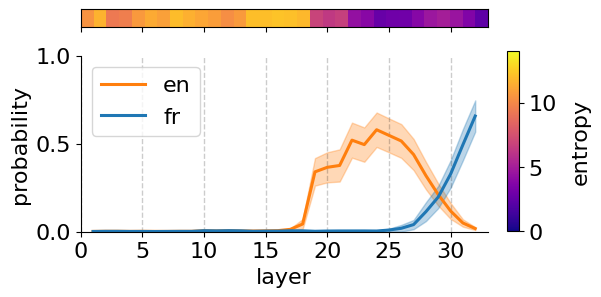

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

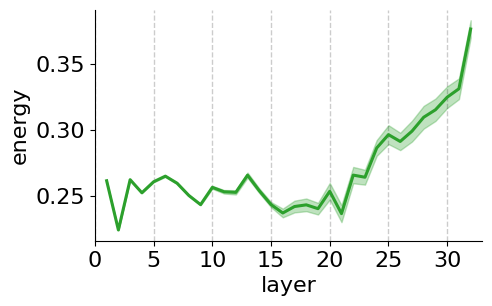

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')